In [ ]:
!pip install h3
!pip install fastexcel
!pip install matplotlib_fontja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.7 MB/s eta 0:00:00


In [ ]:
import polars as pl
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import Point
import h3
import numpy as np
from sklearn.model_selection import KFold

In [ ]:
# polarsの表示設定
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(30)
pl.Config.set_fmt_float("full")
pl.Config.set_float_precision(1)
pl.Config.set_thousands_separator(',')

polars.config.Config

In [ ]:
n_folds = 5
seed = 435
VER = 56
target_col ='money_per_1m2'
MODEL_DATA_PATH = Path('/content/drive/MyDrive/国交省/models')
DATA_PATH = Path('/content/drive/MyDrive/国交省/data')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

In [ ]:
!pip install causallib==0.9.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires

In [ ]:
from causallib.estimation import IPW, PropensityMatching, StratifiedStandardization
from causallib.evaluation import evaluate
from sklearn.linear_model import LogisticRegression

# データ読み込み

In [ ]:
no_reform_df = pl.read_csv(DATA_PATH / 'train_pet.csv')

In [ ]:
data_X = no_reform_df.select(pl.all().exclude('money_per_1m2', 'money_room', 'ペット可否', '二人入居不可110302')).to_pandas()
data_y = no_reform_df.get_column('money_per_1m2').to_pandas()
data_a = no_reform_df.get_column('ペット可否').to_pandas()

In [ ]:
print(f"type(data_X): {type(data_X)}")
print(f"type(data_a): {type(data_a)}")
print(f"type(data_y): {type(data_y)}")

type(data_X): <class 'pandas.core.frame.DataFrame'>
type(data_a): <class 'pandas.core.series.Series'>
type(data_y): <class 'pandas.core.series.Series'>


# 傾向スコアマッチング

In [ ]:
# 傾向スコアを算出するモデルの定義
learner = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
)

# 傾向スコアの算出とマッチング
pm = PropensityMatching(learner=learner)
pm.fit(data_X, data_a, data_y)

PropensityMatching(caliper=None, covariance_conditioner=EmpiricalCovariance(), estimate_observed_outcome=False, knn_backend=sklearn, matching_mode=both, metric=mahalanobis, n_neighbors=1, propensity_transform=PropensityTransformer(learner=LogisticRegression(class_weight='balanced',
                                                 solver='liblinear')), with_replacement=True,
                   learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
# ATEの計算
outcomes = pm.estimate_population_outcome(data_X, data_a) # 処置群と対照群のそれぞれの結果変数の平均値を推定
effect = pm.estimate_effect(outcomes[1], outcomes[0]) # ATEを推定

# 結果の出力
print(f'Average outcome of Untreated: {outcomes[0]:.3f}')
print(f'Average outcome of Treated: {outcomes[1]:.3f}')
print(f'ATE: {effect["diff"]:.3f}')

Average outcome of Untreated: 1798.842
Average outcome of Treated: 1824.269
ATE: 25.427


In [ ]:
# 傾向スコアの取得
propensity_scores = pm.learner.predict_proba(data_X)[:, 1]

# 処置群と対照群に分ける
treatment_group_scores = propensity_scores[data_a == 1]
control_group_scores = propensity_scores[data_a == 0]

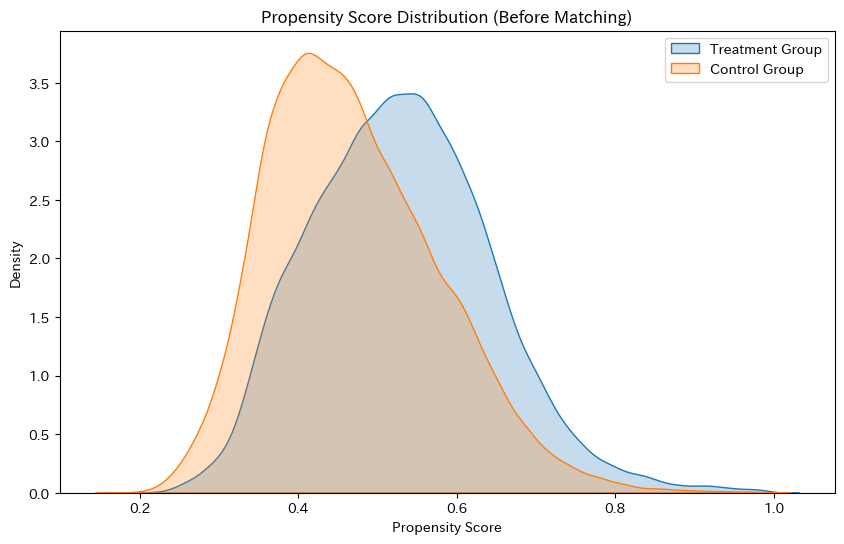

In [ ]:
# 傾向スコア分布のプロット
plt.figure(figsize=(10, 6))
sns.kdeplot(treatment_group_scores, label="Treatment Group", shade=True)
sns.kdeplot(control_group_scores, label="Control Group", shade=True)
plt.title("Propensity Score Distribution (Before Matching)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
print(type(data_X))
print(type(data_a))
print(type(data_y))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
# マッチングされたインデックスを取得
matched_indices = pm.match(data_X, data_a)

# 'matches' 列をフラット化してすべてのインデックスを取得
all_matched_indices = np.concatenate(matched_indices['matches'].values)

# 傾向スコアの取得
propensity_scores = pm.learner.predict_proba(data_X)[:, 1]

# matched_dataを作成
matched_data = pd.DataFrame({
    "treatment": data_a.iloc[all_matched_indices],
    "outcome": data_y.iloc[all_matched_indices],
    "propensity_score": propensity_scores[all_matched_indices]
})

# covariateのカラムをdata_Xから動的に追加
for column in data_X.columns:
    matched_data[column] = data_X.iloc[all_matched_indices][column].values

In [ ]:
matched_data.head()

,treatment,outcome,propensity_score,building_status,building_type,building_structure,floor_count,basement_floor_count,room_floor,bukken_type,...,定期借家権120401,家賃保証付き120801,保証人不要121002,num_of_stations_available,station_num_weight,price_1,target_encoding_station_group_1,target_encoding_h3_index_res5,target_encoding_h3_index_res6,target_encoding_h3_index_res7
0,1,1077,0.570037,1,3,1,3,0,2,1,...,0,0,0,10,36383,120000.0,1365.123457,1287.198793,1244.659808,1380.715026
78762,1,1005,0.419233,1,3,3,2,0,2,1,...,0,0,0,0,0,22000.0,1228.204815,1142.224181,1240.306452,1306.921053
27605,1,765,0.573423,1,3,4,6,0,5,1,...,0,0,0,1,476,67100.0,1021.552632,1102.520408,1052.812500,937.058824
55305,1,941,0.621123,1,1,5,9,0,6,0,...,0,0,1,3,468,37800.0,1069.351351,1185.984663,1142.177083,1014.933333
77267,1,1454,0.369912,1,3,1,2,0,2,1,...,0,0,0,5,26534,105000.0,1659.481481,1696.852236,1832.491525,1733.400000


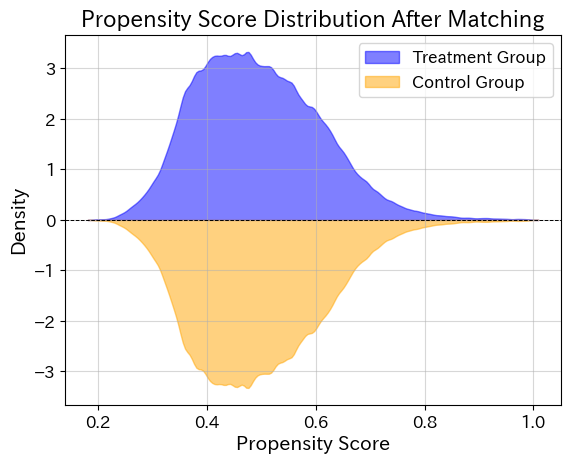

In [ ]:
# 処置群と対照群に分けて傾向スコアを取得
treated_scores = matched_data[matched_data['treatment'] == 1]['propensity_score']
control_scores = matched_data[matched_data['treatment'] == 0]['propensity_score']

# 処置群と対照群のカーネル密度推定を計算
treated_kde = sns.kdeplot(treated_scores, bw_adjust=0.5, color="blue")
treated_x, treated_y = treated_kde.get_lines()[0].get_data()

control_kde = sns.kdeplot(control_scores, bw_adjust=0.5, color="orange")
control_x, control_y = control_kde.get_lines()[0].get_data()

# プロットのクリア（再描画）
plt.clf()

# 処置群の分布
plt.fill_between(treated_x, treated_y, color="blue", alpha=0.5, label="Treatment Group")

# 対照群の分布を上下反転
plt.fill_between(control_x, -control_y, color="orange", alpha=0.5, label="Control Group")

# プロットの装飾
plt.axhline(y=0, color="black", linestyle="--", linewidth=0.7)
plt.title("Propensity Score Distribution After Matching", fontsize=16)
plt.xlabel("Propensity Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)

# プロットの表示
plt.show()

In [ ]:
# 処置群と対照群にデータを分割
treated_data = matched_data[matched_data['treatment'] == 1]
control_data = matched_data[matched_data['treatment'] == 0]

# 分散比を算出
pm_variance_ratios = {}
for col in matched_data.columns:
    if col not in ['treatment', 'outcome', 'propensity_score']:  # 分散比を計算するカラムのみ
        treated_variance = treated_data[col].var(ddof=1)  # 処置群の分散
        control_variance = control_data[col].var(ddof=1)  # 対照群の分散
        pm_variance_ratios[col] = treated_variance / control_variance if control_variance != 0 else None

# 分散比をデータフレームに格納
variance_ratios_df = pd.DataFrame.from_dict(pm_variance_ratios, orient='index', columns=['variance_ratio'])

In [ ]:
variance_ratios_df.sort_values(by='variance_ratio', ascending=False).head(10)

,variance_ratio
楽器相談110101,2.584407
家賃保証付き120801,2.380424
事務所可110201,2.349239
浴室TV223201,1.882175
キッズルーム320501,1.856672
フロントサービス320401,1.743874
石油暖房240103,1.741832
ガス暖房240102,1.637785
シューズインクローゼット253701,1.494587
デザイナーズ330101,1.486427


In [ ]:
# 処置群と対照群にデータを分割
treated_data = matched_data[matched_data['treatment'] == 1]
control_data = matched_data[matched_data['treatment'] == 0]

# SMD を計算
smd_results = {}
for col in matched_data.columns:
    if col not in ['treatment', 'outcome', 'propensity_score']:  # 対象外のカラムを除外
        # 処置群と対照群の平均と分散を計算
        treated_mean = treated_data[col].mean()
        control_mean = control_data[col].mean()
        treated_var = treated_data[col].var(ddof=1)
        control_var = control_data[col].var(ddof=1)

        # 標準化平均差を計算
        pooled_sd = np.sqrt((treated_var + control_var) / 2)
        smd = np.abs(treated_mean - control_mean) / pooled_sd if pooled_sd > 0 else None

        # 結果を格納
        smd_results[col] = smd

# データフレームに変換
smd_df = pd.DataFrame.from_dict(smd_results, orient='index', columns=['absolute_smd'])

# 結果を表示
print(smd_df)

                                 absolute_smd
building_status                      0.000968
building_type                        0.001196
building_structure                   0.021945
floor_count                          0.029032
basement_floor_count                 0.046852
...                                       ...
price_1                              0.006552
target_encoding_station_group_1      0.006559
target_encoding_h3_index_res5        0.006252
target_encoding_h3_index_res6        0.007212
target_encoding_h3_index_res7        0.010605

[124 rows x 1 columns]


In [ ]:
smd_df.sort_values(by='absolute_smd', ascending=False).head(20)

,absolute_smd
単身者限定110501,0.308640
genkyo_code,0.209933
保証人不要121002,0.187425
デザイナーズ330101,0.175962
事務所可110201,0.157949
バイク置き場あり320901,0.155911
学生歓迎110702,0.140826
石油暖房240103,0.134548
ごみ出し24時間OK320201,0.120032
CS対応260201,0.115730


# IPW

In [ ]:
ipw = IPW(learner=learner)
ipw.fit(data_X, data_a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(class_weight='balanced', solver='liblinear'))

In [ ]:
# ATEの計算
outcomes = ipw.estimate_population_outcome(data_X, data_a, data_y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

# 結果の出力
print(f'Average outcome of Untreated: {outcomes[0]:.3f}')
print(f'Average outcome of Treated: {outcomes[1]:.3f}')
print(f'ATE: {effect["diff"]:.3f}')

Average outcome of Untreated: 1822.241
Average outcome of Treated: 1819.223
ATE: -3.018


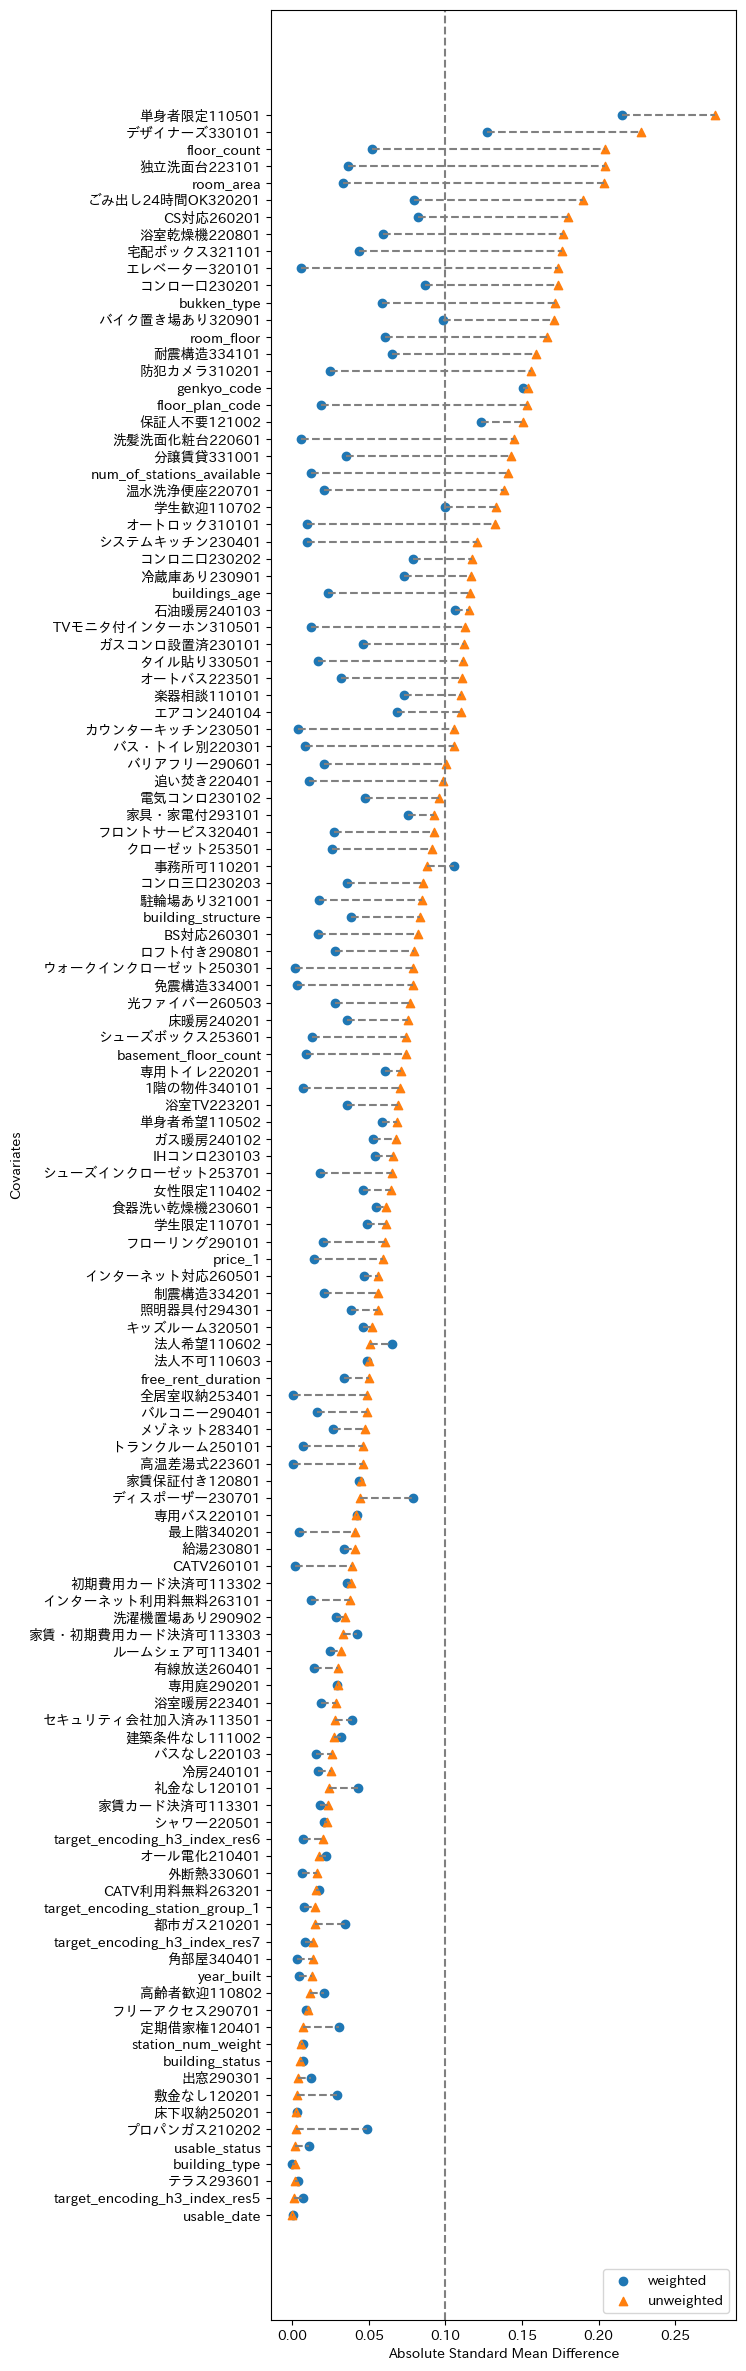

In [ ]:
result = evaluate(ipw, data_X, data_a, data_y)
fig, ax = plt.subplots(1, 1, figsize=(6, 30))
result.plot_covariate_balance(kind='love', ax=ax, thresh=0.1) #ASMDのカットオフ値を0.1に設定
plt.show()

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

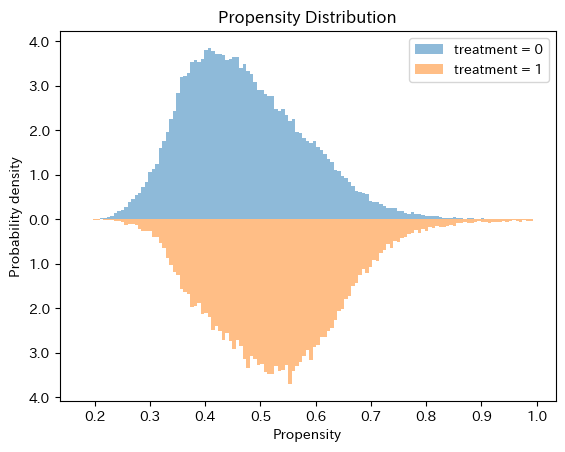

In [ ]:
result.plot_weight_distribution()

In [ ]:
# 重みの計算
weights = ipw.compute_weights(data_X, data_a)

In [ ]:
# 重み付けデータフレームの作成
weighted_data = data_X.copy()
weighted_data["weights"] = weights
weighted_data["treatment"] = data_a

In [ ]:
# 処置群と対照群の分散計算
treatment_data = weighted_data[weighted_data["treatment"] == 1]
control_data = weighted_data[weighted_data["treatment"] == 0]

In [ ]:
# 分散比の計算
variance_ratios = {}
for col in data_X.columns:
    treatment_variance = np.average((treatment_data[col] - treatment_data[col].mean())**2,
                                    weights=treatment_data["weights"])
    control_variance = np.average((control_data[col] - control_data[col].mean())**2,
                                  weights=control_data["weights"])
    variance_ratios[col] = treatment_variance / control_variance

# 結果をデータフレーム化
variance_ratios_df = pl.DataFrame(variance_ratios)

In [ ]:
variance_ratios_df = variance_ratios_df.transpose(include_header=True).rename({'column': 'variable', 'column_0': 'variance_ratio'})

In [ ]:
variance_ratios_df.sort('variance_ratio', descending=True)

variable,variance_ratio
str,f64
"""家賃保証付き120801""",2.4
"""楽器相談110101""",2.3
"""事務所可110201""",2.2
"""石油暖房240103""",1.9
"""ガス暖房240102""",1.7
"""浴室TV223201""",1.7
"""デザイナーズ330101""",1.5
"""メゾネット283401""",1.5
"""genkyo_code""",1.4


# クリッピング

In [ ]:
ipw = IPW(learner=learner, clip_min=0.05, clip_max=0.95)
ipw.fit(data_X, data_a)

# ATEの計算
outcomes = pm.estimate_population_outcome(data_X, data_a) # 処置群と対照群のそれぞれの結果変数の平均値を推定
effect = pm.estimate_effect(outcomes[1], outcomes[0]) # ATEを推定

In [ ]:
# ATEの計算
outcomes = ipw.estimate_population_outcome(data_X, data_a, data_y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])

# 結果の出力
print(f'Average outcome of Untreated: {outcomes[0]:.3f}')
print(f'Average outcome of Treated: {outcomes[1]:.3f}')
print(f'ATE: {effect["diff"]:.3f}')

Average outcome of Untreated: 1813.531
Average outcome of Treated: 1819.279
ATE: 5.748


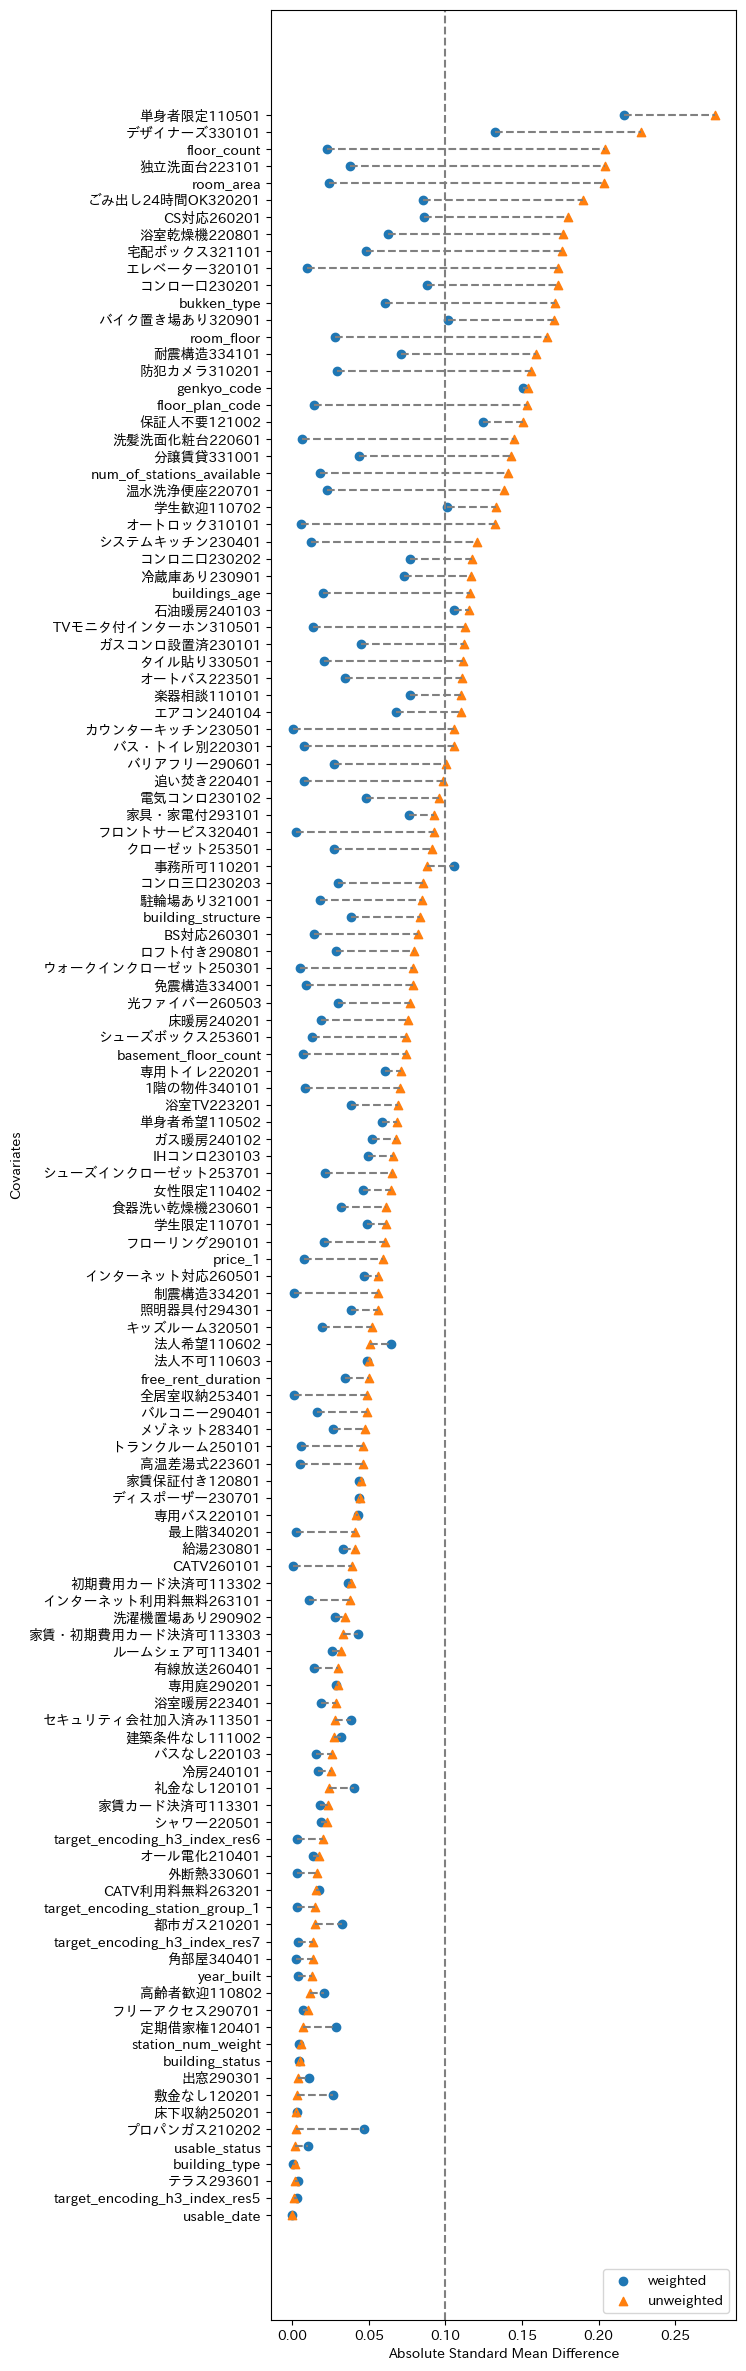

In [ ]:
result = evaluate(ipw, data_X, data_a, data_y)
fig, ax = plt.subplots(1, 1, figsize=(6, 30))
result.plot_covariate_balance(kind='love', ax=ax, thresh=0.1) #ASMDのカットオフ値を0.1に設定
plt.show()

<Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

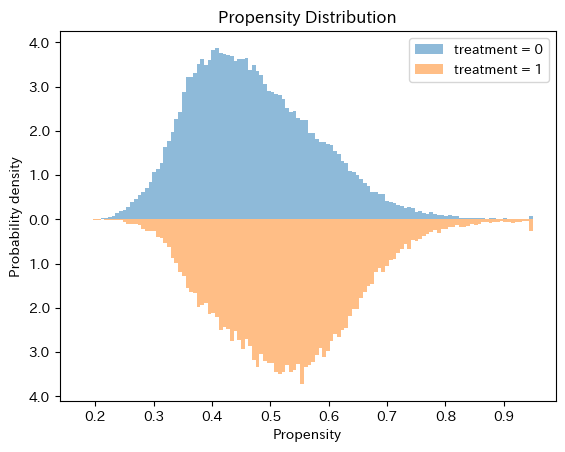

In [ ]:
result.plot_weight_distribution()